# Review: Deep Ensembles for Uncertainty Estimation in Deep Learning

## 0. Libraries & Setup

In [1]:
# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F

# data
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# other
import tqdm as tqdm

Setup the device for the training:

In [2]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


Finally, a function that contains some noise:

In [3]:
# Define the function to be modeled
def f(x):
    return x + np.random.normal(0, 0.1, x.shape[0]) * x ** 2

# Generate input data
X = np.linspace(0, 5, num=1000, endpoint=True)

# Generate target data using the function f(x)
y = f(X)

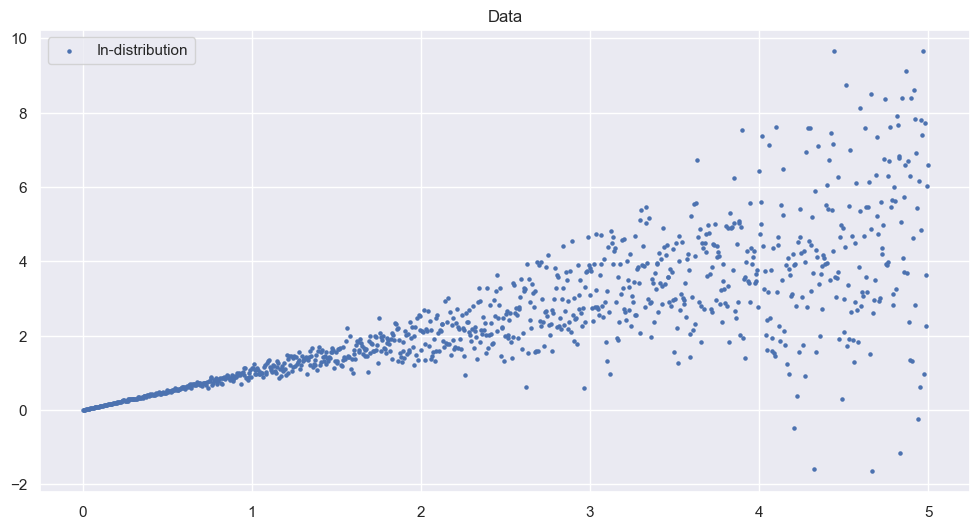

In [4]:
# plot 
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, s=5, label="In-distribution")
plt.legend()
plt.title("Data")
plt.show()

The function is linear with some Gaussian noise added to it that increases with the input value (cone shape).

In [5]:
# Make batch data 
def make_batch(data_size, sample_size, data_x, data_y):
    # Make batches(testing)
    batch_idx = np.random.choice(data_size, sample_size)
    
    batch_x = np.zeros([sample_size, 1])
    batch_y = np.zeros([sample_size, 1])
        
    for i in range(batch_idx.shape[0]):
        batch_x[i,:] = data_x[batch_idx[i]]
        batch_y[i,:] = data_y[batch_idx[i]] 
    
    batch_x = torch.FloatTensor(batch_x).to(device)
    batch_y = torch.FloatTensor(batch_y).to(device)
    
    return batch_x, batch_y  

## I. Deep Ensembles

Instead of using a single model, we use a set of models and average their predictions. This is called an ensemble. The idea is that each model in the ensemble will make different mistakes, so by averaging their predictions, we can reduce the overall error.

In [19]:
class Simple_net(nn.Module):
    def __init__(self, p: int = 0.25) -> None:
        super().__init__()
        
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        
        x = F.relu(self.fc2(x))
        
        x = self.fc3(x)
        
        return x

Setup some training parameters:

In [7]:
num_networks = 10

model_list = []
opt_list = []
criterions = []

for i in range(num_networks):
    model_list.append(Simple_net().to(device))
    opt_list.append(torch.optim.Adam(model_list[i].parameters(), lr = 0.001, betas=(0.9, 0.999)))
    criterions.append(nn.MSELoss())

In [8]:
for i in tqdm.tqdm(range(10_000)):
    for iter in range(num_networks):   
        # model_list[iter].train() 
        # create batch
        batch_x, batch_y = make_batch(X.shape[0], 32, X, y)
        
        # forward pass
        preds = model_list[iter](batch_x)
        
        # positivity constraint
        # sigma_train_pos = torch.log(1 + torch.exp(sigma_train)) + 1e-6
        
        # compute loss
        loss = criterions[iter](preds, batch_y)
        
        # zero grad
        opt_list[iter].zero_grad()
    
        # backward pass
        loss.backward()

        # step
        opt_list[iter].step()
    
    # print each 500 epochs
    if i % 200 == 0:
        print(f"Epoch: {i}, train loss: {loss.item():.4f}")

  0%|          | 3/10000 [00:00<37:13,  4.48it/s]  

Epoch: 0, train loss: 11.8721


  2%|▏         | 203/10000 [00:14<12:25, 13.15it/s]

Epoch: 200, train loss: 1.0293


  4%|▍         | 403/10000 [00:28<11:18, 14.15it/s]

Epoch: 400, train loss: 1.9301


  6%|▌         | 602/10000 [00:44<19:46,  7.92it/s]

Epoch: 600, train loss: 2.1815


  8%|▊         | 803/10000 [00:59<12:16, 12.49it/s]

Epoch: 800, train loss: 0.8689


 10%|█         | 1002/10000 [01:16<18:42,  8.02it/s]

Epoch: 1000, train loss: 0.6701


 12%|█▏        | 1202/10000 [01:34<15:14,  9.62it/s]

Epoch: 1200, train loss: 1.4108


 14%|█▍        | 1403/10000 [01:52<09:25, 15.19it/s]

Epoch: 1400, train loss: 0.5997


 16%|█▌        | 1603/10000 [02:05<09:10, 15.24it/s]

Epoch: 1600, train loss: 1.1091


 18%|█▊        | 1803/10000 [02:18<08:56, 15.28it/s]

Epoch: 1800, train loss: 2.1126


 20%|██        | 2003/10000 [02:32<08:46, 15.19it/s]

Epoch: 2000, train loss: 0.8459


 22%|██▏       | 2203/10000 [02:45<09:30, 13.66it/s]

Epoch: 2200, train loss: 0.9139


 24%|██▍       | 2403/10000 [02:59<08:01, 15.77it/s]

Epoch: 2400, train loss: 0.8808


 26%|██▌       | 2603/10000 [03:14<10:08, 12.16it/s]

Epoch: 2600, train loss: 0.6942


 28%|██▊       | 2803/10000 [03:29<08:49, 13.60it/s]

Epoch: 2800, train loss: 1.6530


 30%|███       | 3003/10000 [03:42<08:19, 14.02it/s]

Epoch: 3000, train loss: 1.4778


 32%|███▏      | 3203/10000 [03:56<07:16, 15.56it/s]

Epoch: 3200, train loss: 0.4401


 34%|███▍      | 3403/10000 [04:11<09:27, 11.62it/s]

Epoch: 3400, train loss: 0.3584


 36%|███▌      | 3603/10000 [04:27<09:06, 11.70it/s]

Epoch: 3600, train loss: 0.8983


 38%|███▊      | 3803/10000 [04:40<06:57, 14.85it/s]

Epoch: 3800, train loss: 0.5076


 40%|████      | 4003/10000 [04:54<06:35, 15.16it/s]

Epoch: 4000, train loss: 1.4369


 42%|████▏     | 4203/10000 [05:08<06:56, 13.91it/s]

Epoch: 4200, train loss: 0.4237


 44%|████▍     | 4403/10000 [05:21<06:06, 15.28it/s]

Epoch: 4400, train loss: 1.8590


 46%|████▌     | 4603/10000 [05:35<06:17, 14.31it/s]

Epoch: 4600, train loss: 1.9299


 48%|████▊     | 4804/10000 [05:52<05:36, 15.44it/s]

Epoch: 4800, train loss: 2.9268


 50%|█████     | 5004/10000 [06:05<05:17, 15.75it/s]

Epoch: 5000, train loss: 2.0924


 52%|█████▏    | 5204/10000 [06:18<05:06, 15.64it/s]

Epoch: 5200, train loss: 1.1983


 54%|█████▍    | 5404/10000 [06:31<04:55, 15.58it/s]

Epoch: 5400, train loss: 1.0979


 56%|█████▌    | 5604/10000 [06:44<04:40, 15.69it/s]

Epoch: 5600, train loss: 0.6198


 58%|█████▊    | 5804/10000 [06:57<04:31, 15.45it/s]

Epoch: 5800, train loss: 1.3978


 60%|██████    | 6004/10000 [07:10<04:15, 15.65it/s]

Epoch: 6000, train loss: 0.7694


 62%|██████▏   | 6204/10000 [07:23<04:05, 15.48it/s]

Epoch: 6200, train loss: 0.2847


 64%|██████▍   | 6404/10000 [07:35<03:51, 15.51it/s]

Epoch: 6400, train loss: 0.7143


 66%|██████▌   | 6604/10000 [07:48<03:35, 15.78it/s]

Epoch: 6600, train loss: 0.8791


 68%|██████▊   | 6804/10000 [08:01<03:23, 15.68it/s]

Epoch: 6800, train loss: 1.3346


 70%|███████   | 7002/10000 [08:14<05:01,  9.94it/s]

Epoch: 7000, train loss: 1.8106


 72%|███████▏  | 7204/10000 [12:06<03:55, 11.88it/s]   

Epoch: 7200, train loss: 0.7631


 74%|███████▍  | 7404/10000 [12:18<01:52, 23.04it/s]

Epoch: 7400, train loss: 0.4214


 76%|███████▌  | 7605/10000 [12:27<01:42, 23.32it/s]

Epoch: 7600, train loss: 2.3850


 78%|███████▊  | 7803/10000 [12:35<01:35, 23.10it/s]

Epoch: 7800, train loss: 0.2752


 80%|████████  | 8004/10000 [12:44<01:26, 23.15it/s]

Epoch: 8000, train loss: 1.2568


 82%|████████▏ | 8205/10000 [12:53<01:17, 23.26it/s]

Epoch: 8200, train loss: 1.0499


 84%|████████▍ | 8403/10000 [13:01<01:09, 22.96it/s]

Epoch: 8400, train loss: 1.5743


 86%|████████▌ | 8604/10000 [13:10<00:59, 23.44it/s]

Epoch: 8600, train loss: 0.7911


 88%|████████▊ | 8805/10000 [13:19<00:51, 23.19it/s]

Epoch: 8800, train loss: 0.7752


 90%|█████████ | 9003/10000 [13:27<00:43, 23.06it/s]

Epoch: 9000, train loss: 1.3149


 92%|█████████▏| 9204/10000 [13:36<00:34, 23.30it/s]

Epoch: 9200, train loss: 2.4439


 94%|█████████▍| 9405/10000 [13:45<00:25, 23.11it/s]

Epoch: 9400, train loss: 1.1079


 96%|█████████▌| 9603/10000 [13:53<00:17, 23.04it/s]

Epoch: 9600, train loss: 0.5496


 98%|█████████▊| 9804/10000 [14:02<00:08, 23.38it/s]

Epoch: 9800, train loss: 1.2238


100%|██████████| 10000/10000 [14:11<00:00, 11.75it/s]


Function that estimates the uncertainty of the ensemble:

In [9]:
def uncertainity_estimate(x, models, num_samples):
    outputs = np.hstack([models[i](x).cpu().detach().numpy() for i in range(num_samples)])
    y_mean = outputs.mean(axis=1)
    y_variance = outputs.var(axis=1)
    y_std = np.sqrt(y_variance)
    return outputs, y_mean, y_std

In [10]:
samples = 100
# compute predictions

# Get Unknown dataset and test
x_sample = np.arange(0, 10 + 0.1, 0.1)
X_sample = np.reshape(x_sample, [x_sample.shape[0], 1])

X_sample_tensor = torch.from_numpy(X_sample).float().to(device)

In [11]:
n_std = 2 # number of standard deviations to plot
outputs, y_mean, y_std = uncertainity_estimate(X_sample_tensor, model_list, num_networks)

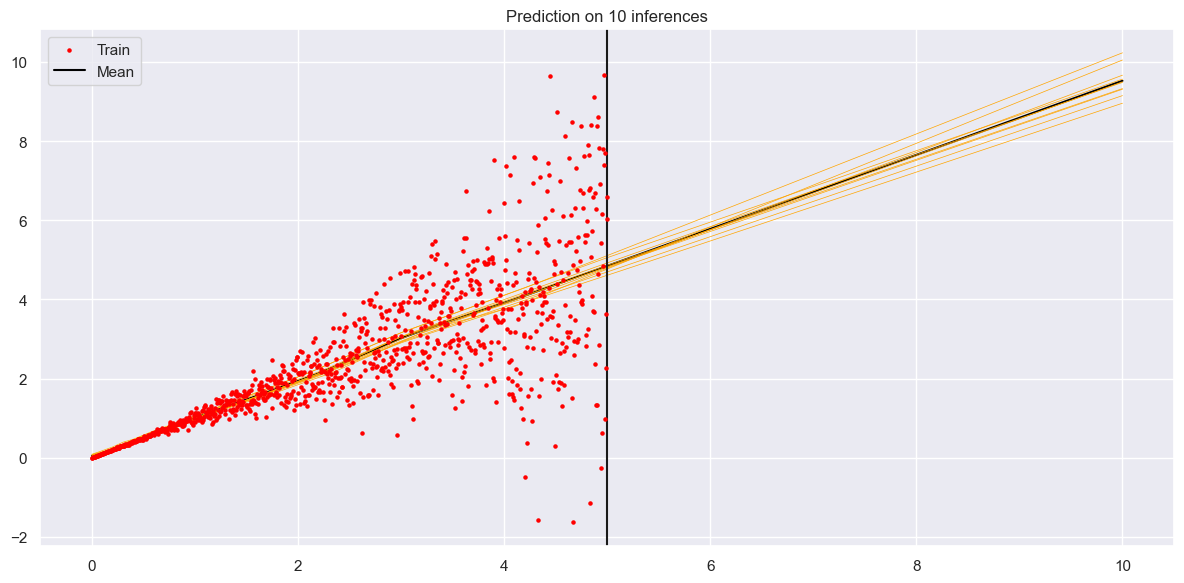

In [12]:
# plot
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
# plt.scatter(X_test, y_test, color="blue", zorder=10, label="Test", s=5)
plt.plot(x_sample, y_mean, color="black", label="Mean")

for i in range(10):
    plt.plot(x_sample, outputs[:, i], color="orange", linewidth=0.5)

plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('Prediction on 10 inferences')
plt.tight_layout()
plt.show()

## II. Uncertainty Estimation

Now, we can plot the uncertainty of the model:

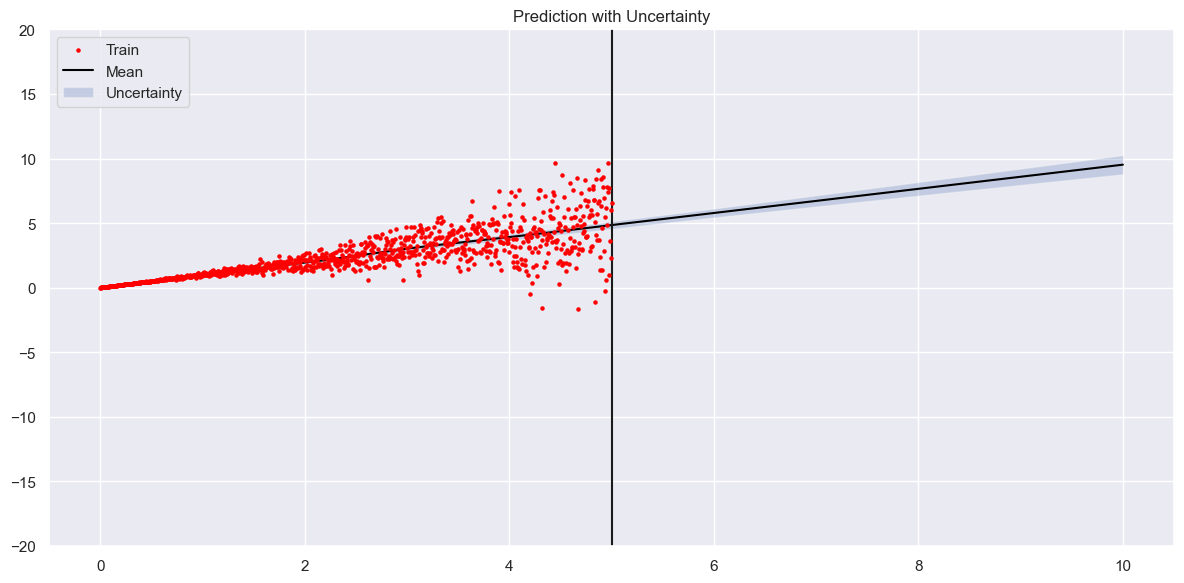

In [13]:
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.plot(x_sample, y_mean, color="black", label="Mean")
plt.fill_between(x_sample, y_mean - n_std * y_std, y_mean + n_std * y_std, alpha=0.25, label="Uncertainty")
plt.ylim([-20, 20])
plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('Prediction with Uncertainty')
plt.tight_layout()
plt.show()

The result show that the uncertainty is quite low compared to the Monte-Carlo Dropout method (see the previous notebook). This is because ensemble methods work by training multiple models independently and  then combining their predictions.

Each model in the ensemble is trained on a different subset of the data or with different initializations, introducing diversity. The idea is that errors in individual models might cancel out when combined, leading to more robust predictions. 

This diversity in the ensemble provieds a natural way to estimate uncertainty because if the models in the ensemble disagree, it suggests uncertainty in the predictions.

In [14]:
# Generate input data
X_ood = np.linspace(5, 10, num=1000, endpoint=True)

# Generate target data using the function f(x)
y_ood = f(X_ood)

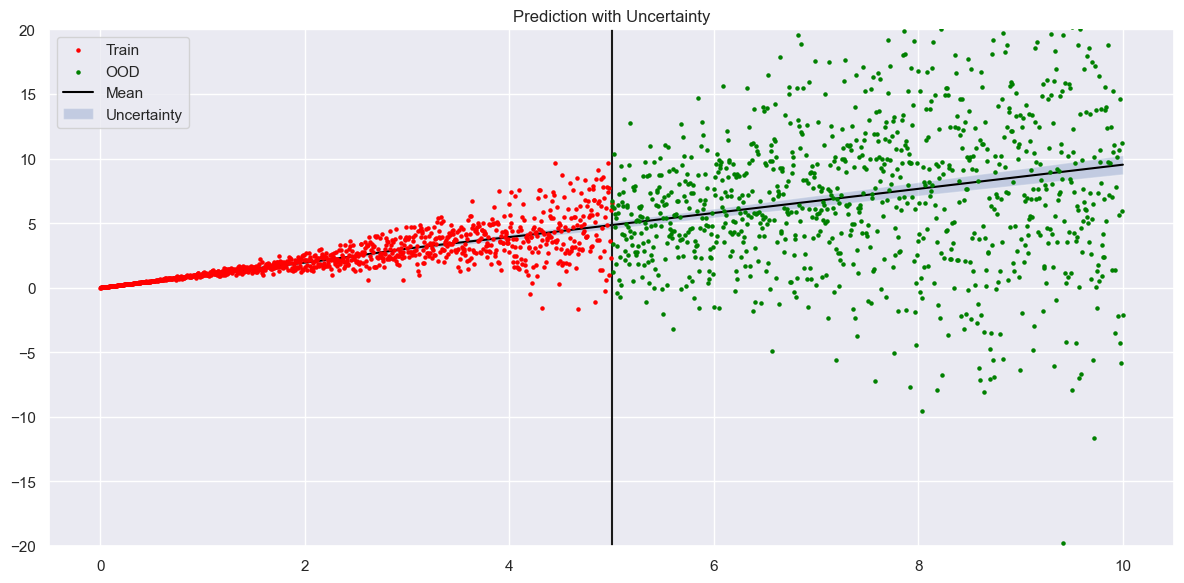

In [15]:
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.scatter(X_ood, y_ood, color="green", zorder=10, label="OOD", s=5)
plt.plot(x_sample, y_mean, color="black", label="Mean")
plt.fill_between(x_sample, y_mean - n_std * y_std, y_mean + n_std * y_std, alpha=0.25, label="Uncertainty")
plt.ylim([-20, 20])
plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('Prediction with Uncertainty')
plt.tight_layout()
plt.show()

However, as shown in the previous figure, the uncertainty coming from the data is not captured by the ensemble.

See notebook "03 - Aleatoric vs Epistemic"

## III. Other studies

Let's remove noise from the data and see what happens:

In [20]:
# Define the function to be modeled
def f(x):
    return x + 0.1 * x ** 2

# Generate input data
X = np.linspace(0, 5, num=1000, endpoint=True)

# Generate target data using the function f(x)
y = f(X)

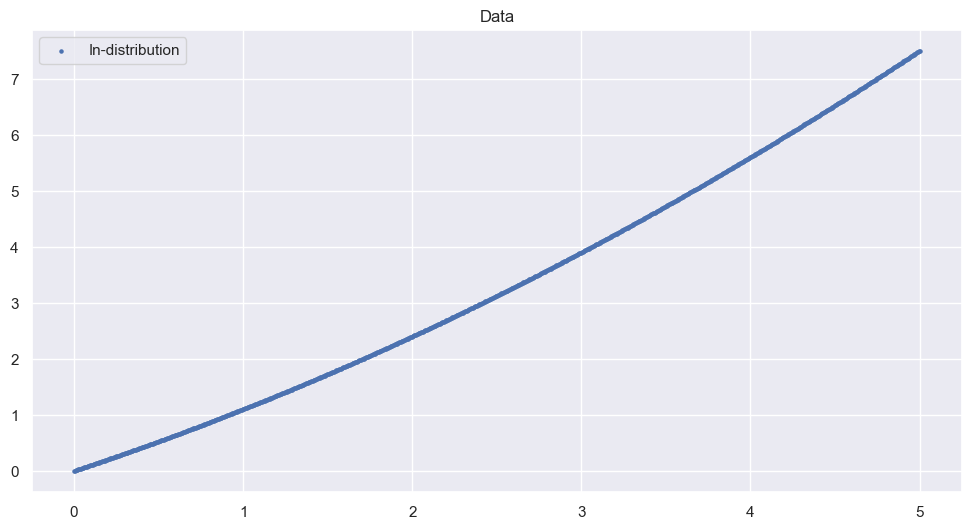

In [21]:
# plot 
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, s=5, label="In-distribution")
plt.legend()
plt.title("Data")
plt.show()

Let's train the models on the data:

In [22]:
num_networks = 10

model_list = []
opt_list = []
criterions = []

for i in range(num_networks):
    model_list.append(Simple_net().to(device))
    opt_list.append(torch.optim.Adam(model_list[i].parameters(), lr = 0.001, betas=(0.9, 0.999)))
    criterions.append(nn.MSELoss())

In [23]:
for i in tqdm.tqdm(range(10_000)):
    for iter in range(num_networks):   
        # model_list[iter].train() 
        # create batch
        batch_x, batch_y = make_batch(X.shape[0], 32, X, y)
        
        # forward pass
        preds = model_list[iter](batch_x)
        
        # compute loss
        loss = criterions[iter](preds, batch_y)
        
        # zero grad
        opt_list[iter].zero_grad()
    
        # backward pass
        loss.backward()

        # step
        opt_list[iter].step()
    
    # print each 500 epochs
    if i % 200 == 0:
        print(f"Epoch: {i}, train loss: {loss.item():.4f}")

  0%|          | 4/10000 [00:00<12:10, 13.68it/s]

Epoch: 0, train loss: 17.1783


  2%|▏         | 204/10000 [00:14<10:38, 15.34it/s]

Epoch: 200, train loss: 0.0135


  4%|▍         | 404/10000 [00:28<10:35, 15.10it/s]

Epoch: 400, train loss: 0.0037


  6%|▌         | 602/10000 [00:41<12:03, 12.99it/s]

Epoch: 600, train loss: 0.0021


  8%|▊         | 802/10000 [00:55<10:26, 14.68it/s]

Epoch: 800, train loss: 0.0022


 10%|█         | 1002/10000 [01:08<10:53, 13.78it/s]

Epoch: 1000, train loss: 0.0010


 12%|█▏        | 1204/10000 [01:22<09:37, 15.23it/s]

Epoch: 1200, train loss: 0.0006


 14%|█▍        | 1402/10000 [01:36<11:14, 12.74it/s]

Epoch: 1400, train loss: 0.0002


 16%|█▌        | 1604/10000 [01:50<09:07, 15.34it/s]

Epoch: 1600, train loss: 0.0005


 18%|█▊        | 1804/10000 [02:04<09:28, 14.41it/s]

Epoch: 1800, train loss: 0.0001


 20%|██        | 2004/10000 [02:18<08:38, 15.42it/s]

Epoch: 2000, train loss: 0.0002


 22%|██▏       | 2204/10000 [02:32<08:07, 15.98it/s]

Epoch: 2200, train loss: 0.0002


 24%|██▍       | 2404/10000 [02:45<07:49, 16.17it/s]

Epoch: 2400, train loss: 0.0001


 26%|██▌       | 2602/10000 [02:58<08:23, 14.68it/s]

Epoch: 2600, train loss: 0.0001


 28%|██▊       | 2804/10000 [03:12<07:54, 15.16it/s]

Epoch: 2800, train loss: 0.0001


 30%|███       | 3002/10000 [03:25<07:42, 15.15it/s]

Epoch: 3000, train loss: 0.0001


 32%|███▏      | 3204/10000 [03:38<07:06, 15.95it/s]

Epoch: 3200, train loss: 0.0001


 34%|███▍      | 3404/10000 [03:51<07:09, 15.34it/s]

Epoch: 3400, train loss: 0.0002


 36%|███▌      | 3602/10000 [04:04<07:05, 15.04it/s]

Epoch: 3600, train loss: 0.0001


 38%|███▊      | 3802/10000 [04:17<06:47, 15.20it/s]

Epoch: 3800, train loss: 0.0001


 40%|████      | 4004/10000 [04:30<06:31, 15.32it/s]

Epoch: 4000, train loss: 0.0001


 42%|████▏     | 4204/10000 [04:45<06:39, 14.52it/s]

Epoch: 4200, train loss: 0.0001


 44%|████▍     | 4404/10000 [04:57<06:00, 15.53it/s]

Epoch: 4400, train loss: 0.0001


 46%|████▌     | 4604/10000 [05:11<05:42, 15.77it/s]

Epoch: 4600, train loss: 0.0001


 48%|████▊     | 4804/10000 [05:23<05:26, 15.89it/s]

Epoch: 4800, train loss: 0.0001


 50%|█████     | 5004/10000 [05:36<05:21, 15.52it/s]

Epoch: 5000, train loss: 0.0001


 52%|█████▏    | 5204/10000 [05:49<05:08, 15.55it/s]

Epoch: 5200, train loss: 0.0001


 54%|█████▍    | 5404/10000 [06:03<04:59, 15.37it/s]

Epoch: 5400, train loss: 0.0000


 56%|█████▌    | 5604/10000 [06:15<04:31, 16.18it/s]

Epoch: 5600, train loss: 0.0000


 58%|█████▊    | 5802/10000 [06:28<04:59, 14.02it/s]

Epoch: 5800, train loss: 0.0001


 60%|██████    | 6004/10000 [06:42<04:12, 15.85it/s]

Epoch: 6000, train loss: 0.0001


 62%|██████▏   | 6204/10000 [06:55<03:57, 16.01it/s]

Epoch: 6200, train loss: 0.0001


 64%|██████▍   | 6404/10000 [07:07<03:43, 16.06it/s]

Epoch: 6400, train loss: 0.0002


 66%|██████▌   | 6604/10000 [07:20<03:31, 16.08it/s]

Epoch: 6600, train loss: 0.0001


 68%|██████▊   | 6804/10000 [07:32<03:22, 15.79it/s]

Epoch: 6800, train loss: 0.0001


 70%|███████   | 7004/10000 [07:45<03:06, 16.04it/s]

Epoch: 7000, train loss: 0.0001


 72%|███████▏  | 7204/10000 [07:57<02:54, 16.01it/s]

Epoch: 7200, train loss: 0.0001


 74%|███████▍  | 7404/10000 [08:10<02:43, 15.86it/s]

Epoch: 7400, train loss: 0.0001


 76%|███████▌  | 7604/10000 [08:23<02:28, 16.16it/s]

Epoch: 7600, train loss: 0.0000


 78%|███████▊  | 7804/10000 [08:36<02:18, 15.84it/s]

Epoch: 7800, train loss: 0.0001


 80%|████████  | 8004/10000 [08:49<02:03, 16.14it/s]

Epoch: 8000, train loss: 0.0000


 82%|████████▏ | 8204/10000 [09:02<01:48, 16.60it/s]

Epoch: 8200, train loss: 0.0001


 84%|████████▍ | 8402/10000 [09:15<02:00, 13.27it/s]

Epoch: 8400, train loss: 0.0001


 86%|████████▌ | 8604/10000 [09:28<01:27, 16.03it/s]

Epoch: 8600, train loss: 0.0001


 88%|████████▊ | 8804/10000 [09:41<01:14, 15.98it/s]

Epoch: 8800, train loss: 0.0000


 90%|█████████ | 9004/10000 [09:53<01:02, 16.06it/s]

Epoch: 9000, train loss: 0.0000


 92%|█████████▏| 9204/10000 [10:06<00:50, 15.91it/s]

Epoch: 9200, train loss: 0.0000


 94%|█████████▍| 9404/10000 [10:19<00:37, 15.85it/s]

Epoch: 9400, train loss: 0.0000


 96%|█████████▌| 9604/10000 [10:31<00:24, 15.87it/s]

Epoch: 9600, train loss: 0.0001


 98%|█████████▊| 9804/10000 [10:44<00:12, 15.79it/s]

Epoch: 9800, train loss: 0.0000


100%|██████████| 10000/10000 [10:56<00:00, 15.23it/s]


In [24]:
samples = 100
# compute predictions

# Get Unknown dataset and test
x_sample = np.arange(0, 10 + 0.1, 0.1)

X_sample = np.reshape(x_sample, [x_sample.shape[0], 1])

X_sample_tensor = torch.from_numpy(X_sample).float().to(device)

In [25]:
n_std = 2 # number of standard deviations to plot
outputs, y_mean, y_std = uncertainity_estimate(X_sample_tensor, model_list, num_networks)

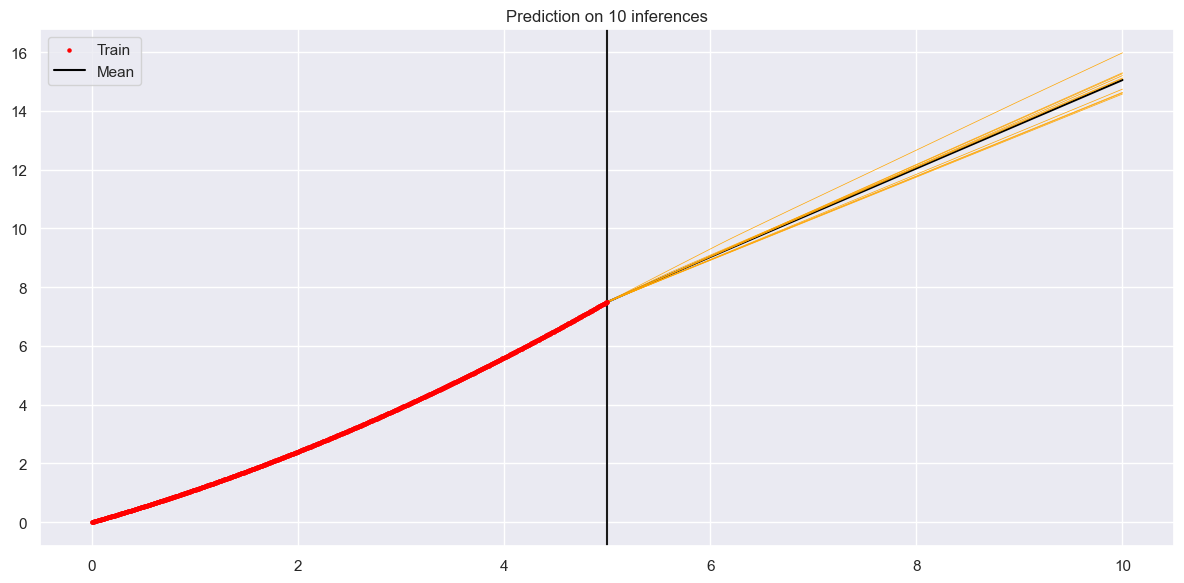

In [26]:
# plot
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
# plt.scatter(X_test, y_test, color="blue", zorder=10, label="Test", s=5)
plt.plot(x_sample, y_mean, color="black", label="Mean")

for i in range(10):
    plt.plot(x_sample, outputs[:, i], color="orange", linewidth=0.5)

plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('Prediction on 10 inferences')
plt.tight_layout()
plt.show()

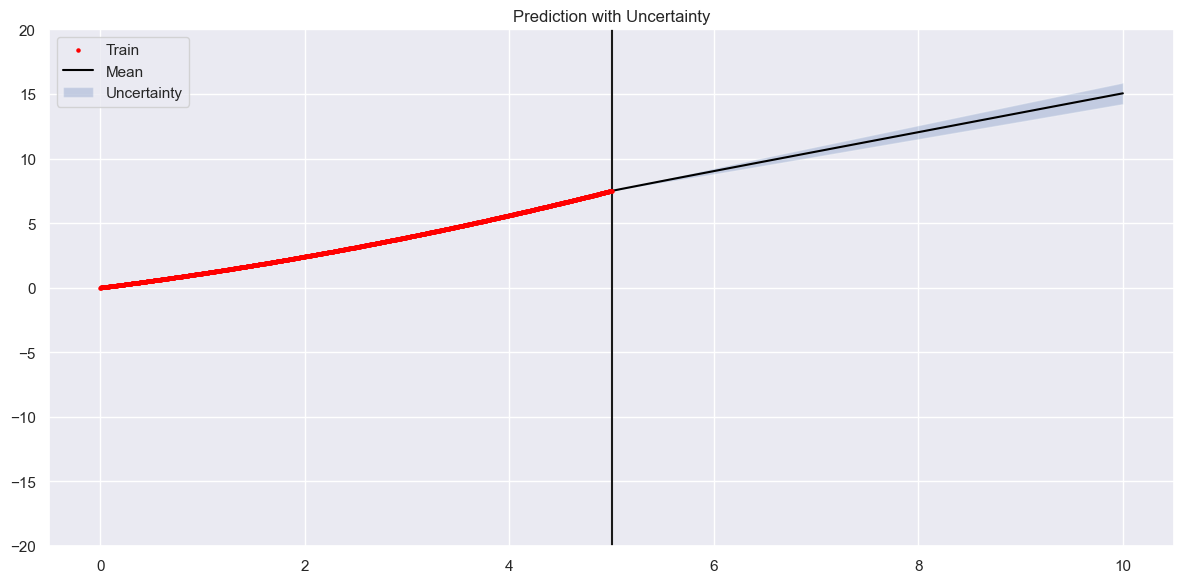

In [27]:
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.plot(x_sample, y_mean, color="black", label="Mean")
plt.fill_between(x_sample, y_mean - n_std * y_std, y_mean + n_std * y_std, alpha=0.25, label="Uncertainty")
plt.ylim([-20, 20])
plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('Prediction with Uncertainty')
plt.tight_layout()
plt.show()

In [28]:
# Generate input data
X_ood = np.linspace(5, 10, num=1000, endpoint=True)

# Generate target data using the function f(x)
y_ood = f(X_ood)

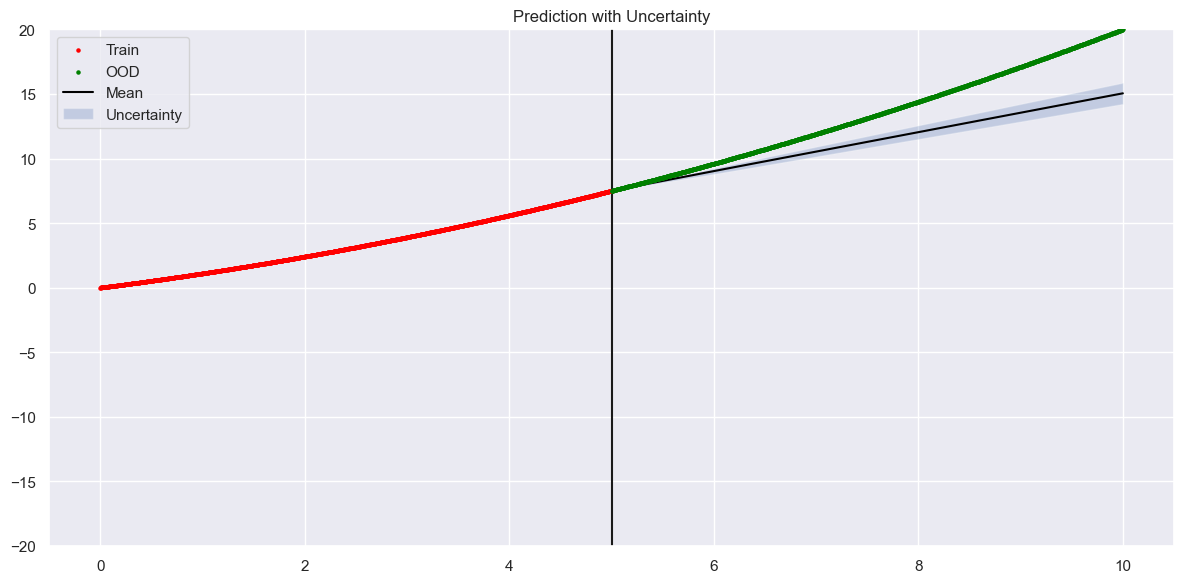

In [29]:
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.scatter(X_ood, y_ood, color="green", zorder=10, label="OOD", s=5)
plt.plot(x_sample, y_mean, color="black", label="Mean")
plt.fill_between(x_sample, y_mean - n_std * y_std, y_mean + n_std * y_std, alpha=0.25, label="Uncertainty")
plt.ylim([-20, 20])
plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('Prediction with Uncertainty')
plt.tight_layout()
plt.show()